In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [2]:
from sklearn.manifold import TSNE # sklearn 사용하면 easy !! 
from sklearn.decomposition import PCA
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn.functional as F
from pseudo_label import gmm
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

In [39]:
### load data ####

## show shffle index image
from image_list import ImageList
from utils import get_augmentation
import cv2
val_transform = get_augmentation("five_crop")
val_dataset = ImageList(
        image_root='/mnt/data/VISDA-C/',
        label_file='/mnt/data/VISDA-C/validation_list.txt',
        transform=val_transform,
    )
test_tranform = get_augmentation('test')

test_dataset = ImageList(
        image_root='/mnt/data/VISDA-C/',
        label_file='/mnt/data/VISDA-C/validation_list.txt',
        transform=get_augmentation("test"),
    )



In [40]:
all_image_path = [i[0] for i in val_dataset.item_list]

In [43]:
a = '/mnt/data/VISDA-C/validation/knife/knife_1520621.jpg'
for idx,i in enumerate(all_image_path): 
    if i == a: 
        print(idx)
        save_idx = idx
    

26903


In [60]:
o_image = test_dataset.__getitem__(save_idx)

images = val_dataset.__getitem__(save_idx)
aug_crop_images = torch.cat([test_tranform(i).unsqueeze(0) for i in images[0]])
aug_crop_images = torch.cat([o_image[0].unsqueeze(0),aug_crop_images])
print(o_image[1:])

(5, 26903)


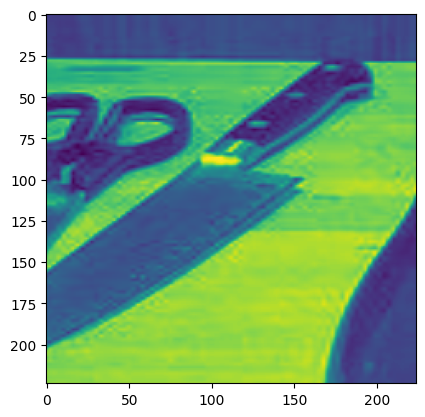

In [51]:
plt.imshow(o_image[0][0])

In [7]:
### load model ####
from classifier import Classifier
from moco.builder import AdaMoCo
from hydra import compose, initialize
from omegaconf import OmegaConf
try:
    initialize(config_path="configs", job_name="root")
except: 
    pass
over = []

args = compose(config_name="root",overrides=['+model_src.num_classes=12'])

args.data.data_root="/mnt/data/"
args.data.workers=8
args.data.dataset="VISDA-C"
args.data.source_domains="[train]"
args.data.target_domains="[validation]"
args.model_src.arch="resnet101"
args.model_tta.src_log_dir="/opt/tta/AdaContrast/checkpoint/VISDA-C/"
args.seed = 2020
# args = OmegaConf.to_yaml(cfg)
# args = OmegaConf.load("/opt/tta/cmpark_AdaContrast/configs/root.yaml")

checkpoint_path = os.path.join(
        args.model_tta.src_log_dir,
        f"best_train_{args.seed}.pth.tar",
    )

src_model = Classifier(args, True, checkpoint_path)
momentum_model = Classifier(args, True, checkpoint_path)
model = AdaMoCo(
    src_model,
    momentum_model,
    K=args.model_tta.queue_size,
    m=args.model_tta.m,
    T_moco=args.model_tta.T_moco
)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [61]:
model = model.to('cuda')
aug_crop_images = aug_crop_images.to('cuda')
feats_w, logits_w = model(aug_crop_images, cls_only=True)

In [62]:
import torch.nn.functional as F
class_name = ['Aeroplane', 'Bicycle', 'Bus', 'Car', 
              'Horse', 'Knife', 'Motorcycle', 'Person', 
              'Plant', 'Skateboard', 'Train', 'Truck']
class_dict = {idx:i for idx, i in enumerate(class_name)}
s_logits_w = F.softmax(logits_w,dim=1)

In [64]:
print(s_logits_w)
[class_dict[i.item()] for i in s_logits_w.argmax(1)]

tensor([[0.0325, 0.0615, 0.0226, 0.0151, 0.1867, 0.0385, 0.0933, 0.0234, 0.1306,
         0.1116, 0.0173, 0.2669],
        [0.0500, 0.0483, 0.2624, 0.1387, 0.0484, 0.0522, 0.1526, 0.0533, 0.0814,
         0.0172, 0.0588, 0.0366],
        [0.0361, 0.1200, 0.0666, 0.0270, 0.0848, 0.0676, 0.0697, 0.1276, 0.0351,
         0.0838, 0.2066, 0.0749],
        [0.1055, 0.0515, 0.0181, 0.2030, 0.0332, 0.0699, 0.0242, 0.1454, 0.1264,
         0.0745, 0.0925, 0.0560],
        [0.1030, 0.0402, 0.2882, 0.0631, 0.0684, 0.1077, 0.1517, 0.0429, 0.0358,
         0.0318, 0.0167, 0.0505],
        [0.1038, 0.0415, 0.0633, 0.1053, 0.0254, 0.0691, 0.0362, 0.0578, 0.0273,
         0.1407, 0.3077, 0.0219]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


['Truck', 'Bus', 'Train', 'Car', 'Bus', 'Train']